<a href="https://colab.research.google.com/github/PJZoio/DocProduct/blob/master/Classification_(FTIR_NIR)_Doenca_Sem_preprocessamento_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (r2_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay, roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score, auc)
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns
import pickle
import seaborn as sns
import xgboost as xgb
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
from google.colab import files
import io

In [ ]:
# Load the dataset
uploaded = files.upload()

Saving Compostas (Novas) - Espetros-Doenca.csv to Compostas (Novas) - Espetros-Doenca.csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded['Compostas (Novas) - Espetros-Doenca.csv']), delimiter=';', encoding='latin-1')
print(data)

    Unnamed: 0        type  Doenca  Conc    12497,1   12495,17   12493,24  \
0        #1##1  Creatinine       0  0,71  0,3190747  0,3190013  0,3184121   
1        #1##2  Creatinine       0  0,71  0,3184985  0,3193123  0,3186378   
2        #1##3  Creatinine       0  0,71  0,3175368  0,3171732  0,3170539   
3        #1##4  Creatinine       0  0,71  0,3169154  0,3159791  0,3152222   
4        #1##5  Creatinine       0  0,71  0,3188727  0,3191647  0,3183154   
..         ...         ...     ...   ...        ...        ...        ...   
265     #54##1  Creatinine       1   6,6  0,2990442  0,2984389  0,2985225   
266     #54##2  Creatinine       1   6,6  0,3004497  0,3007593  0,3000701   
267     #54##3  Creatinine       1   6,6  0,2974475  0,2982265  0,2988065   
268     #54##4  Creatinine       1   6,6  0,2990757  0,2983191  0,2977589   
269     #54##5  Creatinine       1   6,6  0,2974968  0,2986111  0,2994829   

      12491,31   12489,38   12487,46  ...     4017,2   4015,271   4013,343 

In [ ]:
# Replace commas with periods in numeric columns
for column in data.columns:
  # Check if the column data type is 'object' (likely string) before applying str methods
   if data[column].dtype == 'object':
    # Try converting the column to numeric, errors='coerce' will replace invalid values with NaN
    data[column] = pd.to_numeric(data[column].str.replace(',', '.', regex=True), errors='coerce')
    # Now fill NaN values with 0. This is a simple choice, consider other imputation strategies if necessary
    data[column] = data[column].fillna(0)

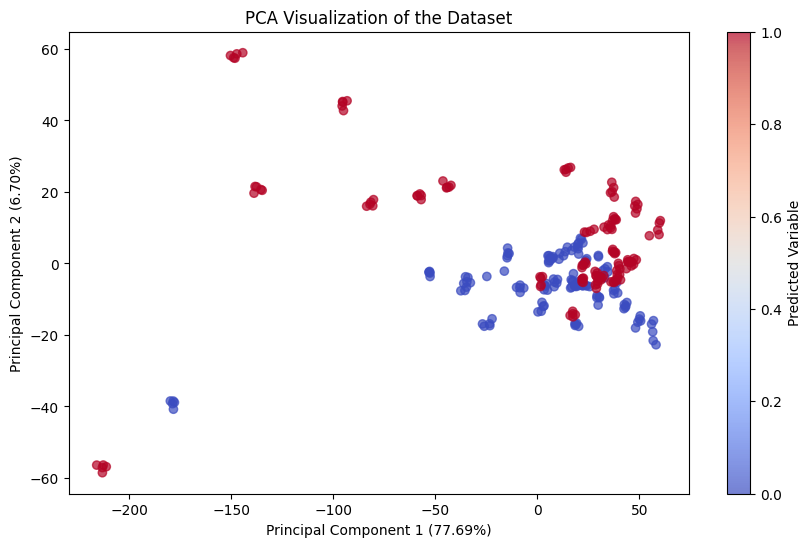

Random Forest - ROC AUC: 1.0000 (95% CI: 1.0000 - 1.0000)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - ROC AUC: 0.9988 (95% CI: 0.9939 - 1.0000)
Logistic Regression - ROC AUC: 0.9994 (95% CI: 0.9963 - 1.0000)


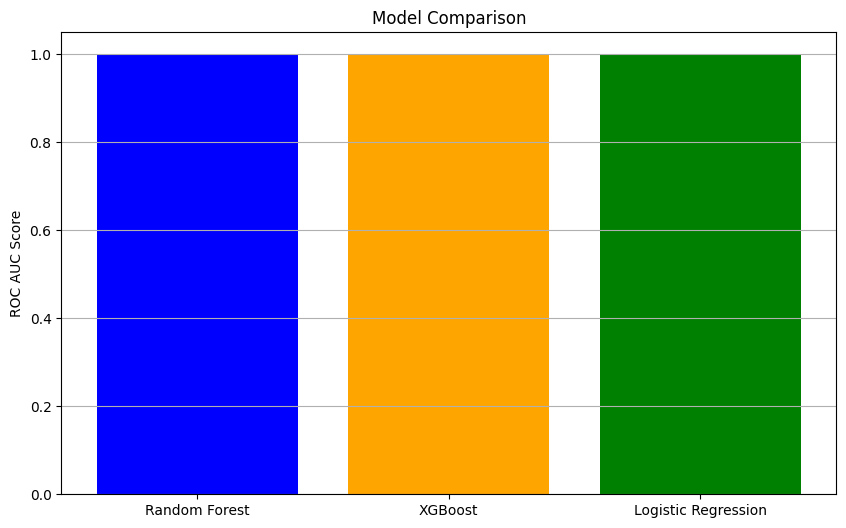

Best Model: Random Forest
Accuracy: 0.9877
Precision: 0.9879
Recall: 0.9877
F1 Score: 0.9876
ROC AUC: 1.0000


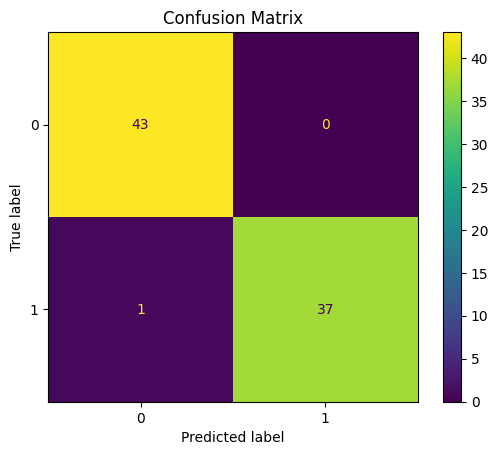

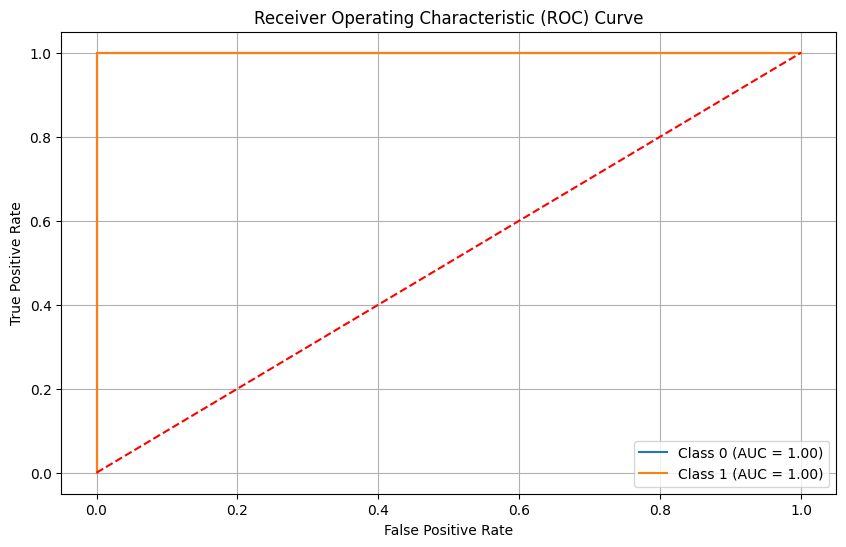

Random Forest - ROC AUC: 1.0000 (95% CI: 1.0000 - 1.0000)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - ROC AUC: 0.9988 (95% CI: 0.9963 - 0.9963)
Logistic Regression - ROC AUC: 0.9994 (95% CI: 1.0000 - 1.0000)


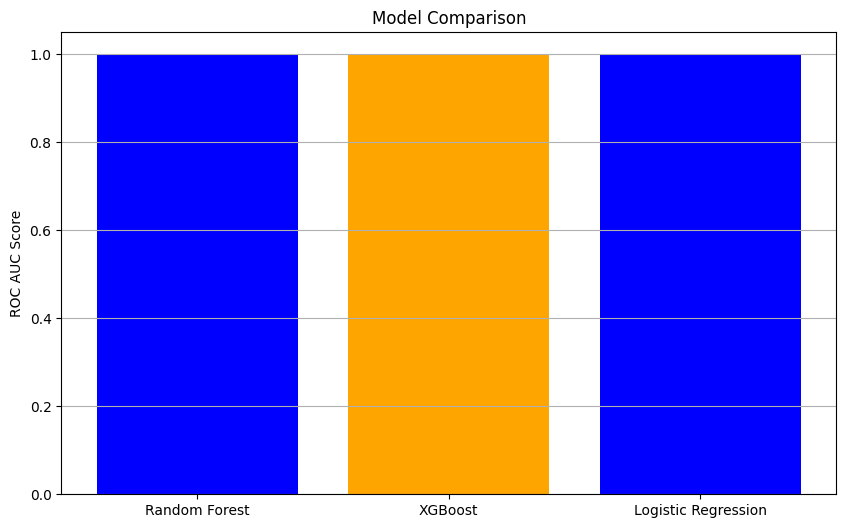


Summary of Model Performance:
Empty DataFrame
Columns: []
Index: []
Best Model: Random Forest
Accuracy: 0.9877
Precision: 0.9879
Recall: 0.9877
F1 Score: 0.9876
ROC AUC: 1.0000


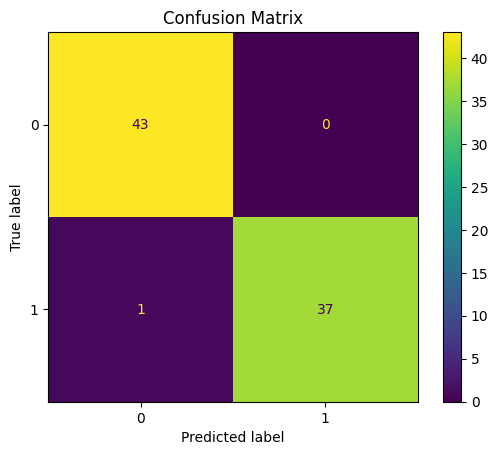

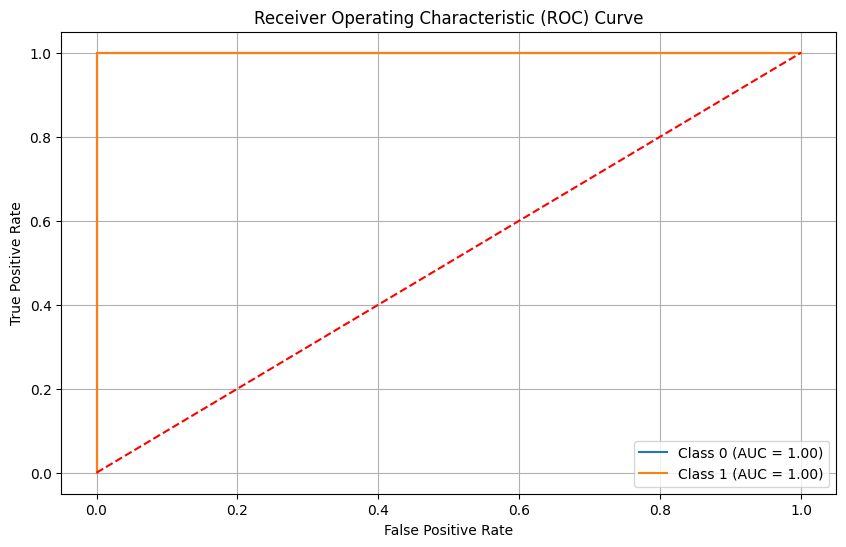

In [ ]:
# Extract the target and feature columns
target = data['Doenca']

features = data.iloc[:, 5:]  # Assuming wavelength data starts at column E

# Perform PCA visualization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features_scaled)
explained_variance = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=target, cmap='coolwarm', alpha=0.7)
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}%)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}%)')
plt.title('PCA Visualization of the Dataset')
cbar = plt.colorbar(scatter)
cbar.set_label('Predicted Variable')
plt.show()

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Cross-validation and model evaluation
cv_folds = 5
auc_scores = {}
models = {}
metrics_results = {}

for name, clf in classifiers.items():
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)
    # Adjust target variable for XGBoost
    #if name == "XGBoost":
    #    y_train = y_train - 1  # Shift labels down by 1
     #   y_test = y_test - 1   # Shift labels down by 1 for testing as well

    clf.fit(X_train, y_train)

    y_proba = clf.predict_proba(X_test)

    # Check if it's a binary classification problem and adjust accordingly
    if y_proba.shape[1] == 2:  # Binary classification
        # Use probabilities for the positive class only
        y_proba = y_proba[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    auc_scores[name] = roc_auc
    models[name] = clf

    # Adjust predictions for XGBoost (shift back up for evaluation)
    #if name == "XGBoost":
     #   y_pred = clf.predict(X_test) + 1
    y_proba = clf.predict_proba(X_test) # Probabilities remain the same

    # Bootstrapping for confidence interval
    bootstrapped_scores = []
    for _ in range(1000):
        indices = np.random.randint(0, len(y_test), len(y_test))
        unique_classes_resampled = np.unique(y_test.iloc[indices])
        if len(unique_classes_resampled) < len(np.unique(y_test)):
            continue

        resampled_y_proba = clf.predict_proba(X_test[indices])

        # Select probabilities for the positive class if binary classification
        if resampled_y_proba.shape[1] == 2:
            resampled_y_proba = resampled_y_proba[:, 1]

        score = roc_auc_score(y_test.iloc[indices], resampled_y_proba, multi_class='ovr')
        bootstrapped_scores.append(score)
    ci_lower, ci_upper = np.percentile(bootstrapped_scores, [2.5, 97.5])
    print(f"{name} - ROC AUC: {roc_auc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})")

# Model comparison plot
plt.figure(figsize=(10, 6))
plt.bar(auc_scores.keys(), auc_scores.values(), color=['blue', 'orange', 'green']) #added color for the third bar
plt.ylabel("ROC AUC Score")
plt.title("Model Comparison")
plt.grid(axis='y')
plt.show()

# Select the best model
best_model_name = max(auc_scores, key=auc_scores.get)
best_model = models[best_model_name]

# Predict and evaluate best model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Save the best model
with open('best_model.pkl', 'wb') as file:
    pickle.dump((best_model, scaler), file)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
# Get probabilities for the positive class for each class in a one-vs-rest approach
y_probs = best_model.predict_proba(X_test)
n_classes = y_probs.shape[1]  # Get the number of classes

# Calculate and plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# Cross-validation and model evaluation
cv_folds = 5
auc_scores = {}
models = {}
metrics_results = {}

for name, clf in classifiers.items():
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)
    clf.fit(X_train, y_train)

    y_proba = clf.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    auc_scores[name] = roc_auc
    models[name] = clf

    # Bootstrapping for confidence interval
    bootstrapped_scores = []
    for _ in range(1000):
        indices = np.random.randint(0, len(y_test), len(y_test))
        unique_classes_resampled = np.unique(y_test.iloc[indices])
        if len(unique_classes_resampled) < len(np.unique(y_test)):
            continue

        resampled_y_proba = clf.predict_proba(X_test[indices])

        # Select probabilities for the positive class if binary classification
    if resampled_y_proba.shape[1] == 2:
        resampled_y_proba = resampled_y_proba[:, 1] #This line extracts probabilities for the positive class (class 1)

        score = roc_auc_score(y_test.iloc[indices], resampled_y_proba, multi_class='ovr')
        bootstrapped_scores.append(score)
    ci_lower, ci_upper = np.percentile(bootstrapped_scores, [2.5, 97.5])
    print(f"{name} - ROC AUC: {roc_auc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})")

# Model comparison plot
plt.figure(figsize=(10, 6))
plt.bar(auc_scores.keys(), auc_scores.values(), color=['blue', 'orange'])
plt.ylabel("ROC AUC Score")
plt.title("Model Comparison")
plt.grid(axis='y')
plt.show()

# Print metrics for all models
for model_name, metrics in metrics_results.items():
    print(f"{model_name} Metrics:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

# Create a DataFrame for metrics summary
table_df = pd.DataFrame(metrics_results).T
print("\nSummary of Model Performance:")
print(table_df)

# Select the best model
best_model_name = max(auc_scores, key=auc_scores.get)
best_model = models[best_model_name]

# Predict and evaluate best model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Save the best model
with open('best_model.pkl', 'wb') as file:
    pickle.dump((best_model, scaler), file)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
# Get probabilities for the positive class for each class in a one-vs-rest approach
y_probs = best_model.predict_proba(X_test)
n_classes = y_probs.shape[1]  # Get the number of classes

# Calculate and plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Save the best model using the captured best_pls and best_scaler
with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump((clf, scaler), file)

In [ ]:
loaded_model = pickle.load(open('best_rf_model.pkl','rb'))

In [ ]:
uploaded = files.upload()

Saving _Inferencias compostas (creatinina).csv to _Inferencias compostas (creatinina).csv


In [ ]:
# Load new dataset for inference
inference_data = pd.read_csv('_Inferencias compostas (creatinina).csv', delimiter=';', encoding='latin-1')

<ipython-input-47-89d598a57e09>:2: DtypeWarning: Columns (1704) have mixed types. Specify dtype option on import or set low_memory=False.
  inference_data = pd.read_csv('_Inferencias compostas (creatinina).csv', delimiter=';', encoding='latin-1')


<ipython-input-48-a5faf2b45674>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inference_data['Predicted_Class'] = predicted_classes
<ipython-input-48-a5faf2b45674>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inference_data['Predicted_Proba'] = predicted_proba


Inference completed. Results saved to 'inference_results_classification.csv'.


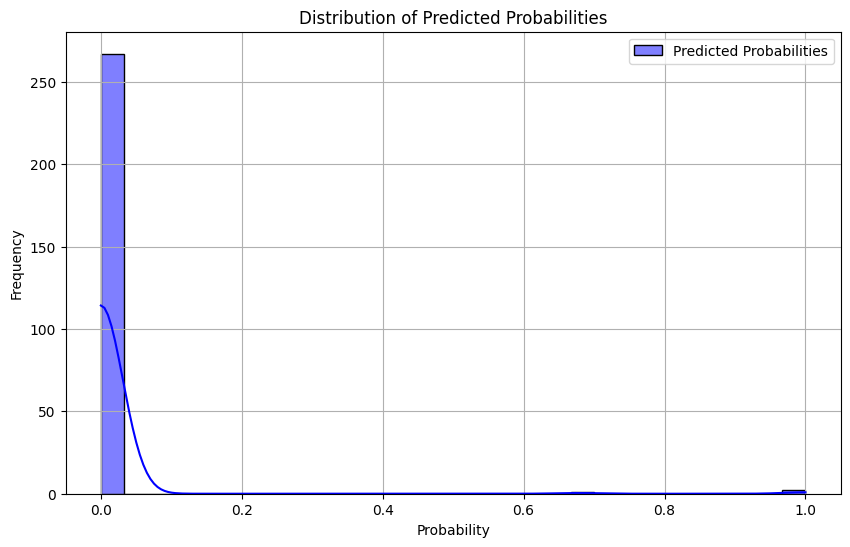

In [ ]:
# Replace commas with periods in numeric columns
for column in inference_data.columns:
    if inference_data[column].dtype == 'object':
        inference_data[column] = pd.to_numeric(inference_data[column].str.replace(',', '.'), errors='coerce').fillna(0)

# Extract features
inference_features = inference_data.reindex(columns=features.columns, fill_value=0)

inference_scaled = scaler.transform(inference_features)

# Predict
predicted_classes = clf.predict(inference_scaled)
predicted_proba = clf.predict_proba(inference_scaled)[:, 1]

# Append predictions
inference_data['Predicted_Class'] = predicted_classes
inference_data['Predicted_Proba'] = predicted_proba

# Save the resulting dataset
inference_data.to_csv('inference_results_classification.csv', index=False, sep=';')
print("Inference completed. Results saved to 'inference_results_classification.csv'.")

# Plot prediction probabilities
plt.figure(figsize=(10, 6))
sns.histplot(predicted_proba, bins=30, kde=True, color='blue', label='Predicted Probabilities')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
files.download('inference_results_classification.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>